In [1]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
import time

rng = np.random.RandomState(42)

N = 4000   
n = 3       # n-parity
timescale=50

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
# train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008003473281860352 seconds ---


In [2]:
def runSomeConfigs(spectral_rad, leak_r, d_t, train_b, test_b, train_t, test_t, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=n_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          delta_t= d_t,
                          sparsity=0.95,
                          noise=0.01,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_b, train_t)
    pred_test = nParityESN.predict(test_b)

    predictedParity = pred_test 
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_t) ** 2))
    print(test_error)
    return test_error

def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
#     train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_targets, test_targets


In [3]:
trials=1
sp_rad = np.linspace(0.1, 1, num=10)
l_rate = np.linspace(0.1, 1, num=10)
num_neurons = 350
delta_t = [0.05, 0.1, 0.15, 0.2]

run_time = time.time()
iterations, iterationcount = trials*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    all_errors = [{} for _ in range(trials)] # empty dict
    for i in range(trials):
        errors = []
        # produce training and testing data
        train_bits, test_bits, train_target, test_target = produceTrainingData(i)
        for l in l_rate:
            for s in sp_rad:
                print("Neurons:", num_neurons,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                errors.append(runSomeConfigs(s,l,dt, train_bits, test_bits, train_target, test_target, num_neurons))
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors[i] = errors

    ### Average errors
    errors_averaged_over_trials = np.zeros(100)
    for i in range(len(all_errors)):
        e = all_errors[i]
        errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
    errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)
    
    delta_t_error.append(errors_averaged_over_trials)
    
print("Total time:")
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 350 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.451087767958
Testing error
0.455416264059
--- Progress: 0.25% --- 0.29 minutes ---
Neurons: 350 Leak-rate: 0.1 Spectral-radius: 0.2 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.432986642452
Testing error
0.441961150465
--- Progress: 0.50% --- 0.56 minutes ---
Neurons: 350 Leak-rate: 0.1 Spectral-radius: 0.3 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.418191564751
Testing error
0.446066278281
--- Progress: 0.75% --- 0.84 minutes ---
Neurons: 350 Leak-rate: 0.1 Spectral-radius: 0.4 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.41929250403
Testing error
0.454185917738
--- Progress: 1.00% --- 1.12 minutes ---
Neurons: 350 Leak-rate: 0.1 Spectral-radius: 0.5 Delta_t: 0.05
harvesting states...
fitting...
training error:
0.4015715235
Testing error
0.472619874031
--- Progress: 1.25% --- 1.40 minutes ---
Neurons: 350 Leak-rate:

In [4]:
import pickle
#### Save Data
# with open('bigESN.p', 'wb') as outputFile:
#     pickle.dump(delta_t_error, outputFile)
#     pickle.dump(num_neurons, outputFile)
#     pickle.dump(delta_t, outputFile)
#     pickle.dump(trials, outputFile)
#     pickle.dump(l_rate, outputFile)
#     pickle.dump(sp_rad, outputFile)
#### Load Data
with open('bigESN.p', 'rb') as inputFile:
    delta_t_error = pickle.load(inputFile)
    num_neurons = pickle.load(inputFile)
    delta_t = pickle.load(inputFile)
    trials = pickle.load(inputFile)
    l_rate = pickle.load(inputFile)
    sp_rad = pickle.load(inputFile)

[0.05, 0.1, 0.15, 0.2]


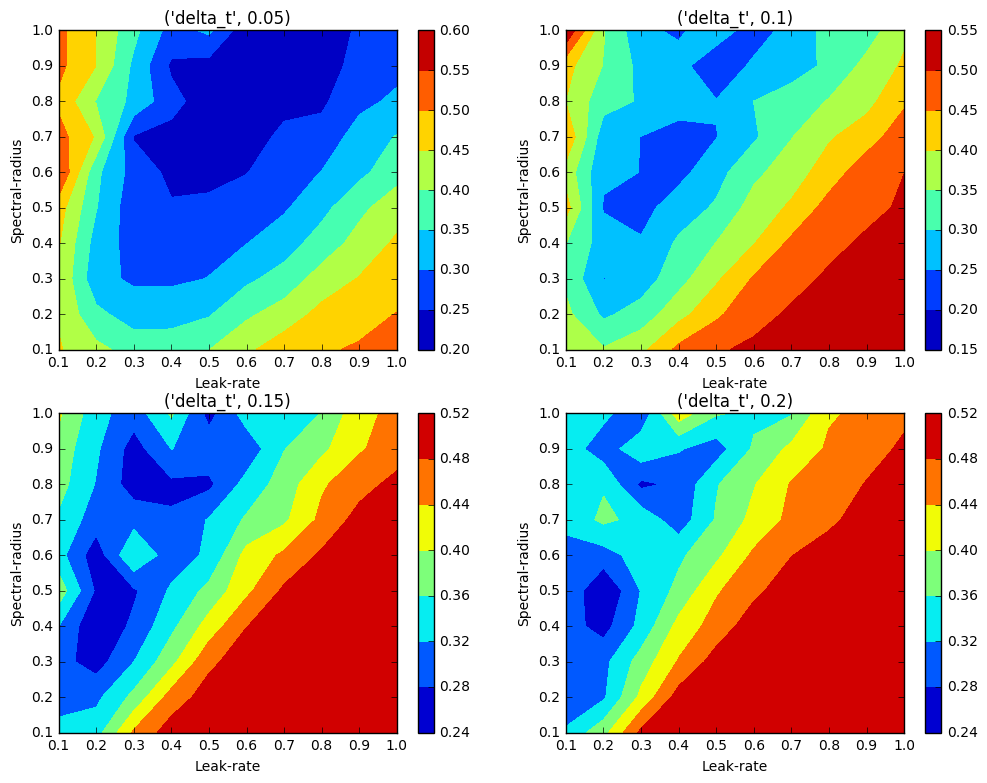

In [5]:
### Plot Errors

from matplotlib import pyplot
%matplotlib inline
print(delta_t)
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_error[p].reshape(10,10).T)
    pyplot.title(("delta_t", delta_t[p]))
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()

In [18]:
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
#     train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

bigESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=350,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.6,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.3,   # adjust leak_rate
                          delta_t= 0.1,
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.01
                          input_shift=0,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False, # No need for teacher forcing because we have no pattern
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
bigESN.fit(train_bits, train_target)#, inspect= True)
pred_test = bigESN.predict(test_bits)

predictedTarget = pred_test
print("Testing error")
test_error = np.sqrt(np.mean((predictedTarget - test_target) ** 2))
print(test_error)

harvesting states...
fitting...
training error:
0.225962132237
Testing error
0.247664006669


60000


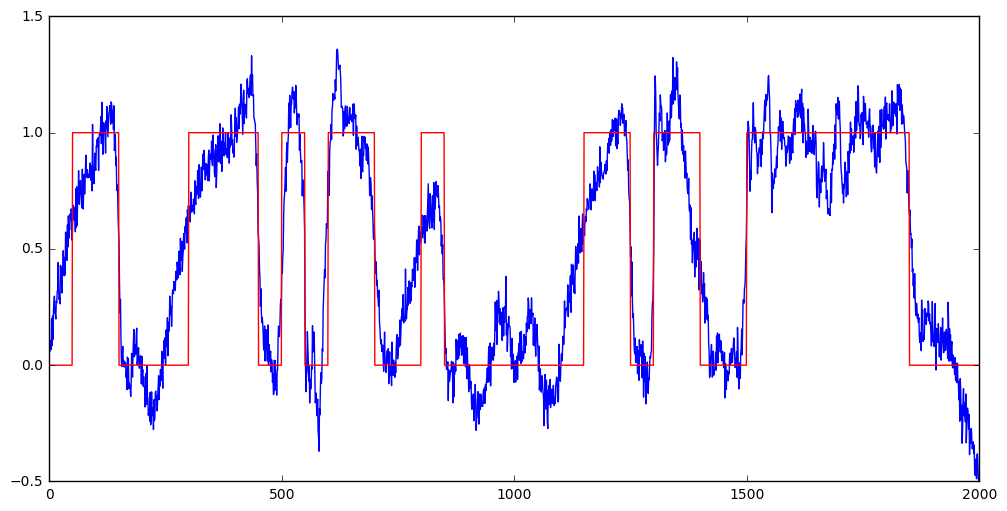

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(111)
print(len(predictedTarget))
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedTarget[6000:8000],"b")
plt.plot(test_target[6000:8000], "r")
plt.show()